## Survival prediction using somatic mutation data

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

### Parameters and data directories

In [2]:
# set results directories
# TODO: document why these need to be different
results_dir = Path(cfg.results_dirs['survival'], 'mutations_me_all')

# set list of PCA component numbers to look for
n_pcs = 10

### Pan-cancer survival prediction, expression vs. methylation

These are models trained and tested on all data types in TCGA, for all samples that have expression and DNA methylation data profiled. We compare against a clinical covariate-only baseline (grey dotted line).

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'vogelstein_mutations': 'all Vogelstein mutations',
    'significant_mutations': 'significant mutations',
    'mutation_preds_expression': 'mutation scores, expression',
    'mutation_preds_me_27k': 'mutation scores, 27k',
    'mutation_preds_me_450k': 'mutation scores, 450k',
}

In [4]:
results_df = su.load_survival_results(results_dir)
results_df.rename(columns={'identifier': 'cancer_type',
                           'fold_no': 'fold'}, inplace=True)
# results_df['n_dim'] = n_dim
results_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(results_df.shape)
print(results_df.training_data.unique())
results_df.head()

(13488, 7)
['baseline' 'mutation scores, 450k' 'gene expression'
 'mutation scores, expression' '450k methylation'
 'all Vogelstein mutations' '27k methylation' 'mutation scores, 27k'
 'significant mutations']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58665,train,THCA,baseline,shuffled,42,0
1,0.58665,cv,THCA,baseline,shuffled,42,0
2,0.64457,test,THCA,baseline,shuffled,42,0
3,0.51805,train,THCA,baseline,shuffled,42,1
4,0.51805,cv,THCA,baseline,shuffled,42,1


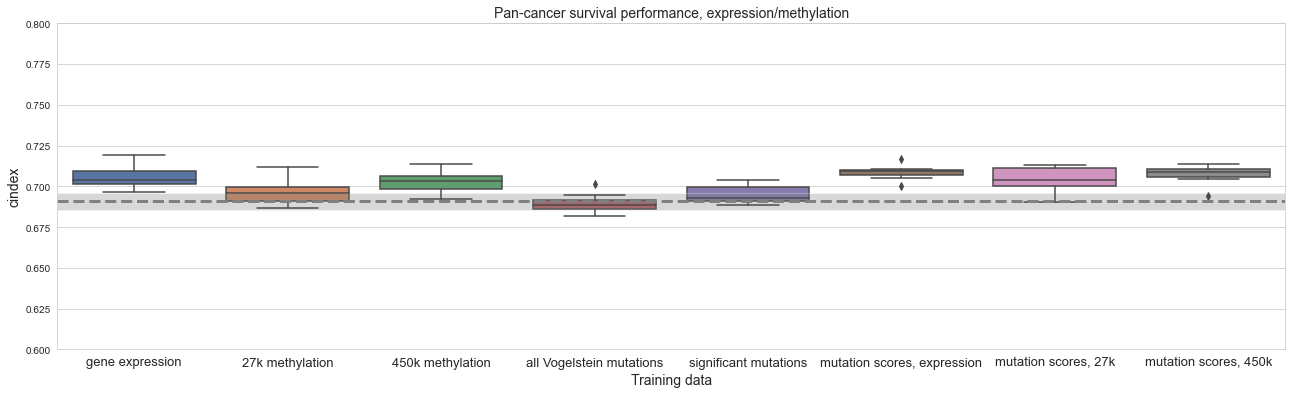

In [12]:
sns.set({'figure.figsize': (22, 6)})
sns.set_style('whitegrid')

plot_df = results_df[(results_df.training_data != 'baseline') &
                     (results_df.cancer_type == 'pancancer') &
                     (results_df.data_type == 'test') &
                     (results_df.signal == 'signal')]
sns.boxplot(data=plot_df, x='training_data', y='cindex',
            order=training_data_map.values())
plt.xlabel('Training data', size=14)
plt.ylabel('cindex', size=14)
plt.title('Pan-cancer survival performance, expression/methylation', size=14)
plt.ylim(0.6, 0.8)
for tick in plt.gca().get_xticklabels():
    tick.set_fontsize(13)

# plot baseline mean/bootstrapped 95% CI
baseline_df = results_df[(results_df.training_data == 'baseline') &
                         (results_df.cancer_type == 'pancancer') &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
baseline_vals = baseline_df.cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

### Individual cancer survival prediction, expression vs. methylation

These are models trained and tested on each individual data type in TCGA, for all samples that have expression and DNA methylation data profiled. Like before, grey dotted lines are clinical covariate-only baselines, for that specific cancer type.

We only ran these experiments using 10 principal components extracted from the -omics datasets, since using more PCs than that led to convergence issues on many cancer types.

In [6]:
group_cancer_types = results_df.groupby(['cancer_type']).count().seed
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LAML',
       'LGG', 'LIHC', 'LUAD', 'LUSC', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC',
       'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCS', 'UVM', 'pancancer'],
      dtype='object', name='cancer_type')


In [7]:
cancer_type_avg = (
    results_df[(results_df.cancer_type.isin(valid_cancer_types)) &
               (results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
ACC          0.757319
pancancer    0.699964
UVM          0.696170
LGG          0.689533
KIRP         0.673309
LAML         0.657353
SARC         0.637206
KIRC         0.633886
GBM          0.603506
BLCA         0.602490
Name: cindex, dtype: float64

In [8]:
cancer_type_sd = (
    results_df[(results_df.cancer_type.isin(valid_cancer_types)) &
               (results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .groupby('cancer_type')
      .std()
).cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    73.934911
LGG          16.184220
BLCA         11.895874
HNSC         11.748054
LAML         11.166247
SKCM         10.456455
LUSC         10.104751
SARC          8.990027
STAD          8.786048
KIRC          8.417293
Name: cindex, dtype: float64

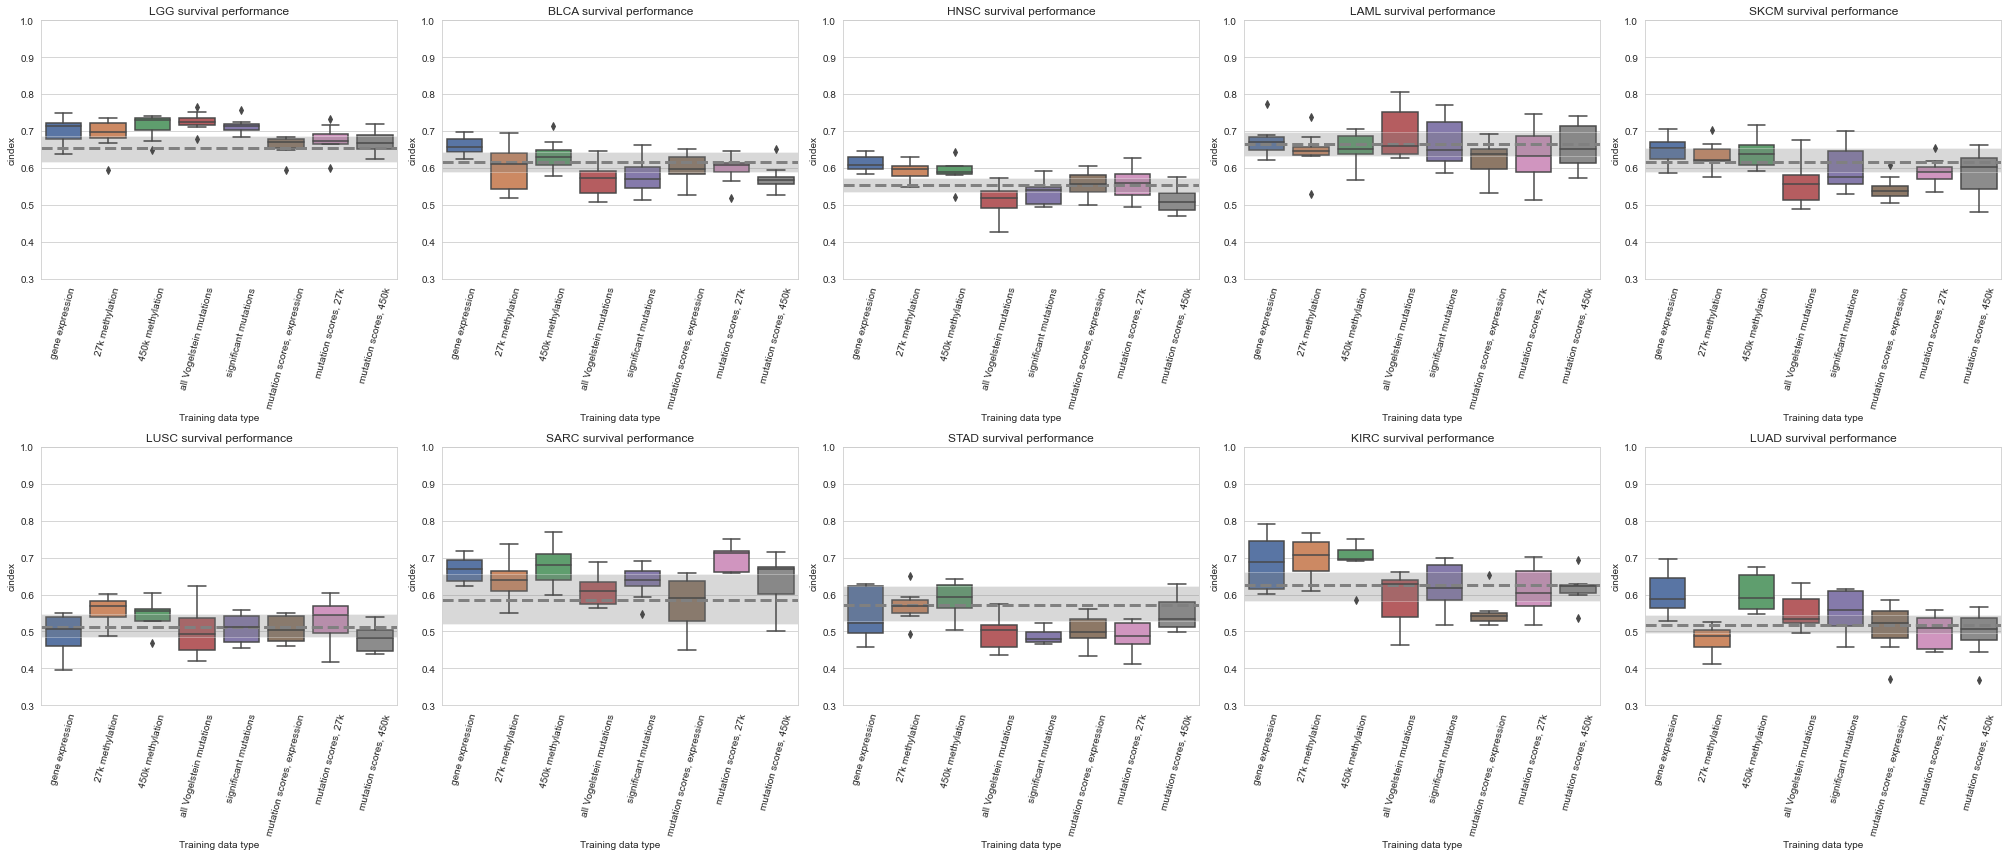

In [9]:
sns.set({'figure.figsize': (28, 12)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(2, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:10]):
    ax = axarr[ix // 5, ix % 5]
    plot_df = results_df[(results_df.training_data != 'baseline') &
                         (results_df.cancer_type == cancer_type) &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
    sns.boxplot(data=plot_df, x='training_data', y='cindex',
                order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Training data type')
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.3, 1.0)
    for tick in ax.get_xticklabels():
        tick.set_rotation(75)
        tick.set_fontsize(13)
        
    # plot baseline mean/bootstrapped 95% CI
    baseline_vals = (results_df
        [(results_df.training_data == 'baseline') &
         (results_df.cancer_type == cancer_type) &
         (results_df.data_type == 'test') &
         (results_df.signal == 'signal')]
    ).cindex.values

    baseline_mean = np.mean(baseline_vals)
    ax.axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

    baseline_ci = sns.utils.ci(
        sns.algorithms.bootstrap(baseline_vals,
                                 func=np.mean,
                                 n_boot=1000,
                                 units=None,
                                 seed=cfg.default_seed)
    )
    ax.axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)
    
plt.tight_layout()

Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

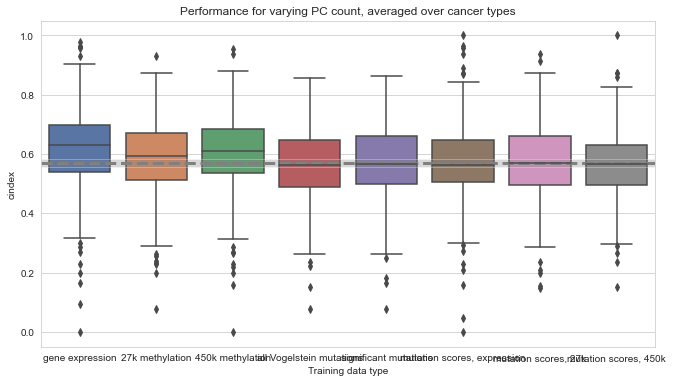

In [10]:
sns.set({'figure.figsize': (11, 6)})
sns.set_style('whitegrid')

plot_df = results_df[(results_df.training_data != 'baseline') &
                     (results_df.data_type == 'test') &
                     (results_df.signal == 'signal')]
sns.boxplot(data=plot_df, x='training_data', y='cindex',
            order=training_data_map.values())

# plot baseline mean/bootstrapped 95% CI
baseline_df = results_df[(results_df.training_data == 'baseline') &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
baseline_vals = baseline_df.cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

plt.xlabel('Training data type')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')